In [32]:
# %% [markdown]
"""
# Conformal Prediction with SVM on the Iris Dataset

This notebook implements split conformal prediction for classification using an SVM on the Iris dataset.

# %% [markdown]
"""
## Cell 1: Import Libraries and Set Up the Environment


# %% [code]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import warnings

# Set random seed for reproducibility
np.random.seed(42)
warnings.filterwarnings("ignore")

print("Libraries imported and environment set up.")

Libraries imported and environment set up.


In [2]:
# %% [markdown]
"""
## Cell 2: Load and Explore the Iris Dataset

We load the Iris dataset, examine its shape and a few example rows.
"""

# %% [code]
iris = load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names

print("Iris dataset shape (features):", X.shape)
print("Iris dataset shape (labels):", y.shape)
print("Target names:", target_names)

# Create a DataFrame for easier visualization
df_iris = pd.DataFrame(X, columns=iris.feature_names)
df_iris['target'] = y
df_iris['target_name'] = df_iris['target'].apply(lambda i: target_names[i])
print("\nFirst 5 rows of the Iris dataset:")
print(df_iris.head())

Iris dataset shape (features): (150, 4)
Iris dataset shape (labels): (150,)
Target names: ['setosa' 'versicolor' 'virginica']

First 5 rows of the Iris dataset:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target target_name  
0       0      setosa  
1       0      setosa  
2       0      setosa  
3       0      setosa  
4       0      setosa  


In [3]:
# %% [markdown]
"""
## Cell 3: Split Data into Training, Calibration, and Test Sets

We split the dataset into three parts:
- **Training set:** Used for fitting the SVM.
- **Calibration set:** Used to compute nonconformity scores.
- **Test set:** Used to evaluate the conformal prediction sets.
"""

# %% [code]
# First, split into training (60%) and temporary set (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
# Then, split temporary set equally into calibration and test (20% each)
X_cal, X_test, y_cal, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Training set shape:", X_train.shape)
print("Calibration set shape:", X_cal.shape)
print("Test set shape:", X_test.shape)


Training set shape: (90, 4)
Calibration set shape: (30, 4)
Test set shape: (30, 4)


In [4]:
# %% [markdown]
"""
## Cell 4: Train SVM Classifier with Probability Estimates

We train an SVM classifier with an RBF kernel and enable probability estimates (which
are needed for computing nonconformity scores).
"""

# %% [code]
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train, y_train)
print("SVM classifier trained.")

SVM classifier trained.


In [5]:
# %% [markdown]
"""
## Cell 5: Evaluate the SVM on Calibration and Test Sets

Before proceeding to conformal prediction, we evaluate the SVM classifier.
"""

# %% [code]
# Evaluate on calibration set
y_cal_pred = svm_model.predict(X_cal)
cal_acc = accuracy_score(y_cal, y_cal_pred)
print("Calibration set accuracy:", cal_acc)

# Evaluate on test set
y_test_pred = svm_model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print("Test set accuracy:", test_acc)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=target_names))

Calibration set accuracy: 0.9333333333333333
Test set accuracy: 1.0

Classification Report (Test Set):
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00        10
   virginica       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [6]:
# %% [markdown]
"""
## Cell 6: Compute Nonconformity Scores on the Calibration Set

"""

# %% [code]
# Obtain probability estimates for the calibration set
cal_probs = svm_model.predict_proba(X_cal)

# Compute nonconformity scores for calibration set
# For each sample i, get the probability assigned to its true class.
cal_true_probs = np.array([cal_probs[i, y_cal[i]] for i in range(len(y_cal))])
cal_nonconformity = 1 - cal_true_probs

print("First 10 calibration nonconformity scores:")
print(cal_nonconformity[:10])

First 10 calibration nonconformity scores:
[0.38716368 0.03517111 0.06804754 0.02983846 0.14542215 0.1502576
 0.03197333 0.0429507  0.01570921 0.03656327]


In [7]:
# %% [markdown]
"""
## Cell 7: Define a Function to Compute p‑Values for a New Test Instance


"""

# %% [code]
def compute_p_values(x, model, cal_nonconf, n_cal):
    """
    For a given test instance x, compute p-values for each candidate class.

    Parameters:
    - x: A test instance (1D numpy array).
    - model: Trained classifier (with predict_proba method).
    - cal_nonconf: Array of calibration nonconformity scores.
    - n_cal: Number of calibration examples.

    Returns:
    - p_values: Dictionary mapping candidate class index to its p-value.
    - nonconf_scores: Dictionary mapping candidate class to nonconformity score.
    """
    probs = model.predict_proba(x.reshape(1, -1))[0]  # predicted probabilities for x
    p_values = {}
    nonconf_scores = {}
    for class_idx, p in enumerate(probs):
        # Compute nonconformity score for candidate class: 1 - p
        alpha = 1 - p
        nonconf_scores[class_idx] = alpha
        # p-value is fraction of calibration nonconformity scores that are >= alpha
        count = np.sum(cal_nonconf >= alpha)
        p_val = (count + 1) / (n_cal + 1)  # +1 for conservative estimate
        p_values[class_idx] = p_val
    return p_values, nonconf_scores

# Test the function on the first test instance
n_cal = len(cal_nonconformity)
test_instance = X_test[0]
p_vals_example, nc_example = compute_p_values(test_instance, svm_model, cal_nonconformity, n_cal)
print("Test instance candidate nonconformity scores:", nc_example)
print("Test instance candidate p-values:", p_vals_example)

Test instance candidate nonconformity scores: {0: 0.9854073382501144, 1: 0.04872991181855879, 2: 0.9658627499313266}
Test instance candidate p-values: {0: 0.03225806451612903, 1: 0.5483870967741935, 2: 0.03225806451612903}


In [9]:
# %% [markdown]
"""
## Cell 8: Construct Conformal Prediction Sets for the Test Set

For each test instance, we compute p‑values for all classes. With a significance level \( \epsilon \)
(e.g., 0.1 for 90% confidence), we include in the prediction set all classes with \( p(y) > \epsilon \).
"""

# %% [code]
# Define significance level (e.g., 0.1 for 90% confidence)
epsilon = 0.1

# For each test instance, compute the conformal prediction set
conformal_sets = []
all_p_values = []  # store p-values for analysis

for x in X_test:
    p_vals, _ = compute_p_values(x, svm_model, cal_nonconformity, n_cal)
    all_p_values.append(p_vals)
    # Prediction set: all classes with p-value > epsilon
    pred_set = [cls for cls, p_val in p_vals.items() if p_val > epsilon]
    conformal_sets.append(pred_set)

# Convert to a more convenient structure
#conformal_sets = np.array(conformal_sets)
print("First 10 conformal prediction sets for test instances:")
for i in range(10):
    # Display candidate class names using iris.target_names
    set_names = [target_names[cls] for cls in conformal_sets[i]]
    print(f"Test instance {i}: {set_names}")

First 10 conformal prediction sets for test instances:
Test instance 0: ['versicolor']
Test instance 1: ['setosa']
Test instance 2: ['versicolor']
Test instance 3: ['setosa']
Test instance 4: ['virginica']
Test instance 5: ['setosa']
Test instance 6: ['versicolor']
Test instance 7: ['setosa']
Test instance 8: ['virginica']
Test instance 9: ['setosa']


In [10]:
# %% [markdown]
"""
## Cell 9: Evaluate Conformal Prediction Performance

We evaluate the conformal predictor by:
- **Coverage:** The fraction of test examples for which the true label is contained in the prediction set.
- **Average Prediction Set Size:** The average number of labels in the prediction set.
"""

# %% [code]
# Compute coverage and average prediction set size
coverage = 0
set_sizes = []

for i in range(len(y_test)):
    pred_set = conformal_sets[i]
    set_sizes.append(len(pred_set))
    if y_test[i] in pred_set:
        coverage += 1

coverage_fraction = coverage / len(y_test)
avg_set_size = np.mean(set_sizes)

print("Conformal Prediction Coverage (fraction):", coverage_fraction)
print("Average Prediction Set Size:", avg_set_size)

Conformal Prediction Coverage (fraction): 0.9
Average Prediction Set Size: 0.9


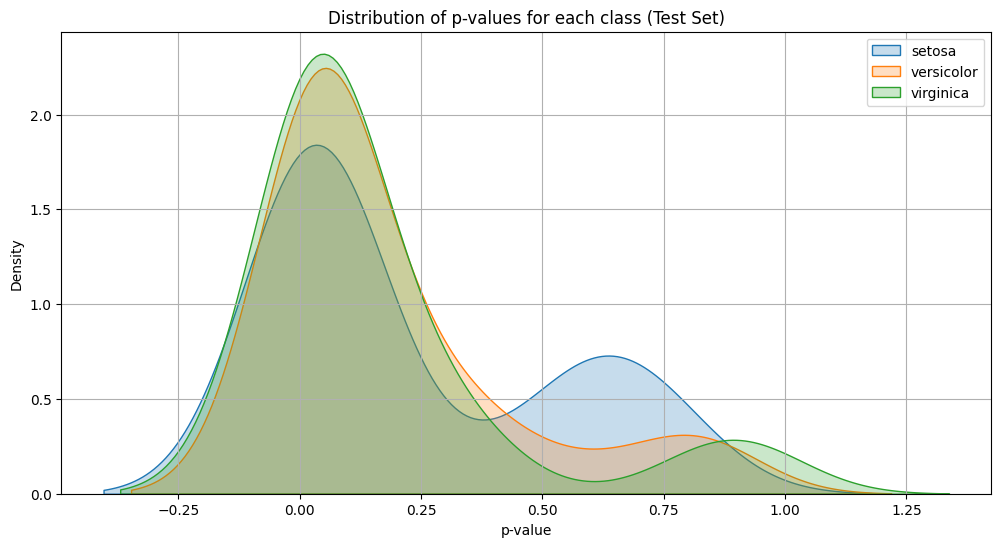

In [11]:
# %% [markdown]
"""
## Cell 10: Visualize p‑Values Distribution on Test Set

We plot the distribution of p‑values for each candidate class across the test set. This helps us
understand the confidence levels the model assigns.
"""

# %% [code]
# For each class, collect all p-values from test instances
p_values_by_class = {cls: [] for cls in range(len(target_names))}

for p_dict in all_p_values:
    for cls, p_val in p_dict.items():
        p_values_by_class[cls].append(p_val)

plt.figure(figsize=(12, 6))
for cls, p_vals in p_values_by_class.items():
    sns.kdeplot(p_vals, label=f"{target_names[cls]}", shade=True)
plt.xlabel("p-value")
plt.ylabel("Density")
plt.title("Distribution of p-values for each class (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# %% [markdown]
"""
## Cell 11: Detailed Analysis for a Few Test Instances

We print out the details (nonconformity scores and p‑values) for a few test instances to inspect
the conformal prediction sets.
"""

# %% [code]
for i in range(5):
    p_vals, nc_scores = compute_p_values(X_test[i], svm_model, cal_nonconformity, n_cal)
    pred_set = [target_names[cls] for cls, p_val in p_vals.items() if p_val > epsilon]
    true_label = target_names[y_test[i]]
    print(f"Test instance {i}:")
    print("  True label:", true_label)
    print("  Nonconformity scores:", {target_names[k]: round(v, 3) for k, v in nc_scores.items()})
    print("  p-values:", {target_names[k]: round(v, 3) for k, v in p_vals.items()})
    print("  Conformal prediction set:", pred_set)
    print("  -->", "Correct" if true_label in pred_set else "Incorrect", "\n")

Test instance 0:
  True label: versicolor
  Nonconformity scores: {'setosa': 0.985, 'versicolor': 0.049, 'virginica': 0.966}
  p-values: {'setosa': 0.032, 'versicolor': 0.548, 'virginica': 0.032}
  Conformal prediction set: ['versicolor']
  --> Correct 

Test instance 1:
  True label: setosa
  Nonconformity scores: {'setosa': 0.034, 'versicolor': 0.978, 'virginica': 0.987}
  p-values: {'setosa': 0.742, 'versicolor': 0.032, 'virginica': 0.032}
  Conformal prediction set: ['setosa']
  --> Correct 

Test instance 2:
  True label: versicolor
  Nonconformity scores: {'setosa': 0.986, 'versicolor': 0.244, 'virginica': 0.77}
  p-values: {'setosa': 0.032, 'versicolor': 0.129, 'virginica': 0.032}
  Conformal prediction set: ['versicolor']
  --> Correct 

Test instance 3:
  True label: setosa
  Nonconformity scores: {'setosa': 0.046, 'versicolor': 0.968, 'virginica': 0.985}
  p-values: {'setosa': 0.581, 'versicolor': 0.032, 'virginica': 0.032}
  Conformal prediction set: ['setosa']
  --> Correct

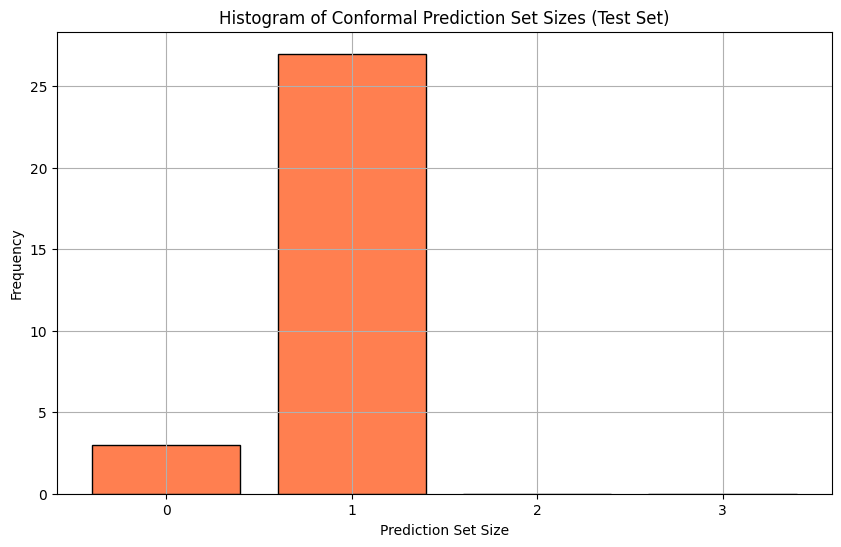

In [13]:
# %% [markdown]
"""
## Cell 12: Visualize Conformal Prediction Set Sizes

We plot a histogram of the sizes (number of labels) of the conformal prediction sets across the test set.
"""

# %% [code]
plt.figure(figsize=(10, 6))
plt.hist(set_sizes, bins=np.arange(0, len(target_names)+2)-0.5, color='coral', edgecolor='k', rwidth=0.8)
plt.xlabel("Prediction Set Size")
plt.ylabel("Frequency")
plt.title("Histogram of Conformal Prediction Set Sizes (Test Set)")
plt.xticks(range(len(target_names)+1))
plt.grid(True)
plt.show()

In [14]:
# %% [markdown]
"""
## Cell 13: Summary Metrics

We print a final summary of the conformal prediction results on the Iris test set:
- Coverage (fraction of test examples where the true label is in the prediction set).
- Average size of the prediction sets.
- (Optional) A brief classification accuracy for the underlying SVM.
"""

# %% [code]
print("=== Conformal Prediction Summary ===")
print("Significance Level (epsilon):", epsilon)
print("Coverage (Test Set):", coverage_fraction)
print("Average Prediction Set Size:", avg_set_size)
print("Underlying SVM Test Accuracy:", test_acc)

=== Conformal Prediction Summary ===
Significance Level (epsilon): 0.1
Coverage (Test Set): 0.9
Average Prediction Set Size: 0.9
Underlying SVM Test Accuracy: 1.0


In [15]:

# %% [markdown]
"""
# Cell 14: End of Notebook

In this notebook, we applied split conformal prediction with an SVM on the Iris dataset.
We computed nonconformity scores on the calibration set, constructed conformal prediction sets
for the test instances, and evaluated the coverage and average size of these sets.

Feel free to adjust the significance level \( \epsilon \) and explore the results.
Happy experimenting with conformal prediction!
"""

'\n# Cell 14: End of Notebook\n\nIn this notebook, we applied split conformal prediction with an SVM on the Iris dataset.\nWe computed nonconformity scores on the calibration set, constructed conformal prediction sets\nfor the test instances, and evaluated the coverage and average size of these sets.\n\nFeel free to adjust the significance level \\( \\epsilon \\) and explore the results.\nHappy experimenting with conformal prediction!\n'

In [17]:
# %% [markdown]
"""
# Additional Plots for Prediction Performance and Uncertainty Estimation
This section provides extra visualizations:
- A confusion matrix of the underlying SVM classifier.
- A calibration (reliability) diagram of the SVM predicted probabilities.
- A boxplot of conformal prediction set sizes by true class.
- A scatter plot comparing nonconformity scores and p‑values.
- A coverage vs. significance level curve.
- A bar plot of average p‑values for each true class.
"""

'\n# Additional Plots for Prediction Performance and Uncertainty Estimation\nThis section provides extra visualizations:\n- A confusion matrix of the underlying SVM classifier.\n- A calibration (reliability) diagram of the SVM predicted probabilities.\n- A boxplot of conformal prediction set sizes by true class.\n- A scatter plot comparing nonconformity scores and p‑values.\n- A coverage vs. significance level curve.\n- A bar plot of average p‑values for each true class.\n'

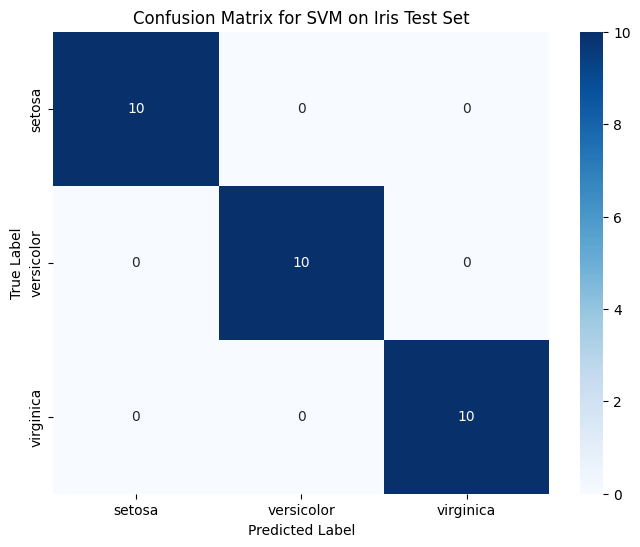

In [18]:
# %% [markdown]
"""
## Cell A: Confusion Matrix for SVM Predictions
We plot a confusion matrix (with a heatmap) for the SVM classifier on the test set.
This helps assess the overall prediction performance.
"""

# %% [code]
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix for the underlying SVM predictions on the test set.
cm = confusion_matrix(y_test, svm_model.predict(X_test))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for SVM on Iris Test Set")
plt.show()


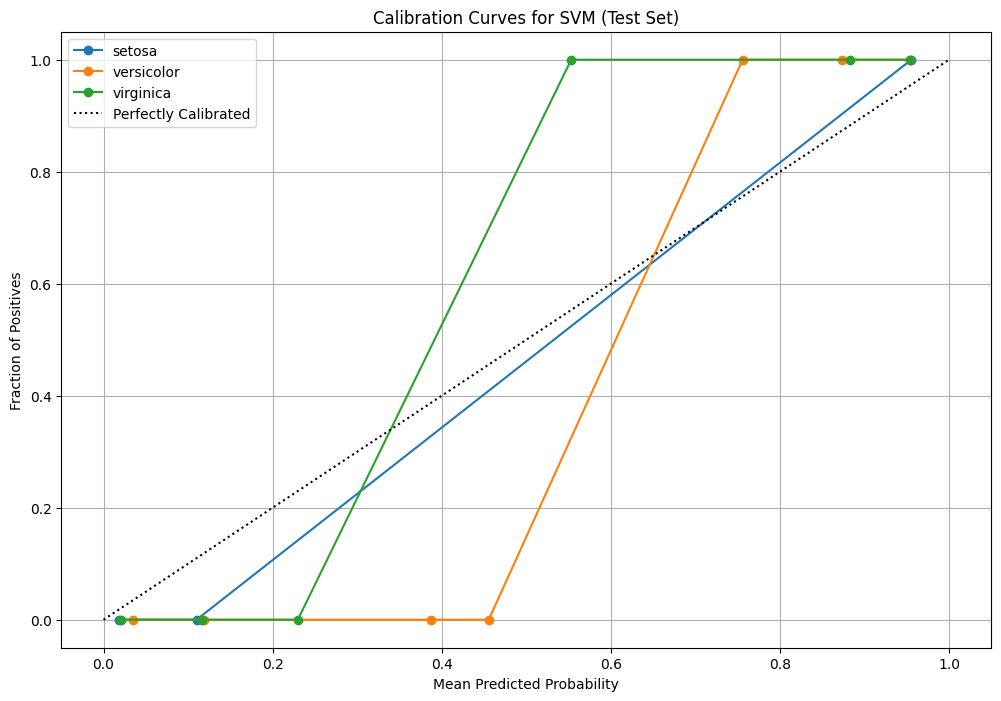

In [19]:
# %% [markdown]
"""
## Cell B: Calibration (Reliability) Diagram for SVM Probabilities
We create a reliability diagram comparing predicted probabilities to true outcomes.
This diagram helps assess whether the probability estimates are well calibrated.
"""

# %% [code]
from sklearn.calibration import calibration_curve

# Obtain predicted probabilities for the test set for one class (e.g., 'setosa' as an example).
# We'll compute the calibration curve for each class separately.
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(target_names):
    # Binary labels: 1 if true label equals class i, 0 otherwise.
    y_true_binary = (y_test == i).astype(int)
    prob_pos = svm_model.predict_proba(X_test)[:, i]
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true_binary, prob_pos, n_bins=10, strategy='uniform')
    plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label=f"{class_name}")

plt.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curves for SVM (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

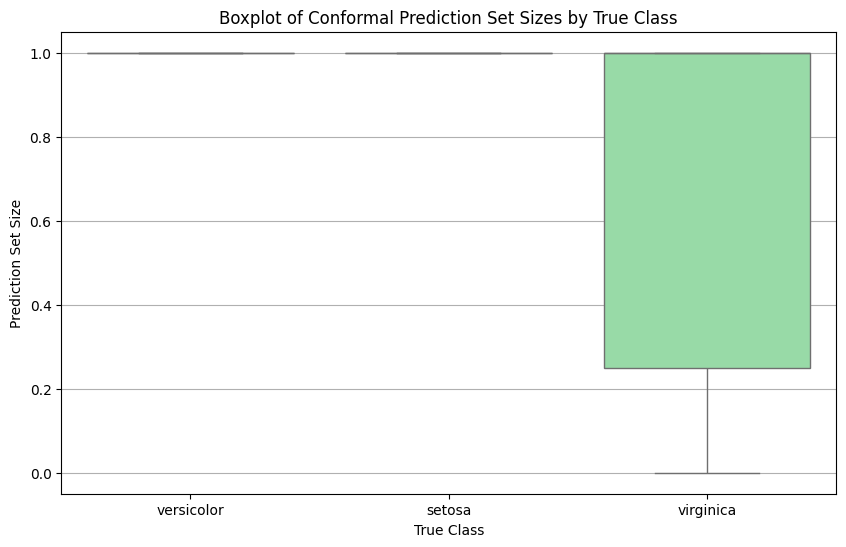

In [20]:
# %% [markdown]
"""
## Cell C: Boxplot of Conformal Prediction Set Sizes by True Class
We create a boxplot showing the distribution of conformal prediction set sizes (i.e., number of labels predicted) for each true class.
This can reveal if certain classes tend to have larger (or smaller) prediction sets.
"""

# %% [code]
# First, create a DataFrame with true labels and the size of each conformal prediction set.
pred_set_sizes = [len(pred_set) for pred_set in conformal_sets]
df_conformal = pd.DataFrame({
    "True Label": [target_names[label] for label in y_test],
    "Prediction Set Size": pred_set_sizes
})

plt.figure(figsize=(10, 6))
sns.boxplot(x="True Label", y="Prediction Set Size", data=df_conformal, palette="pastel")
plt.title("Boxplot of Conformal Prediction Set Sizes by True Class")
plt.xlabel("True Class")
plt.ylabel("Prediction Set Size")
plt.grid(True, axis="y")
plt.show()


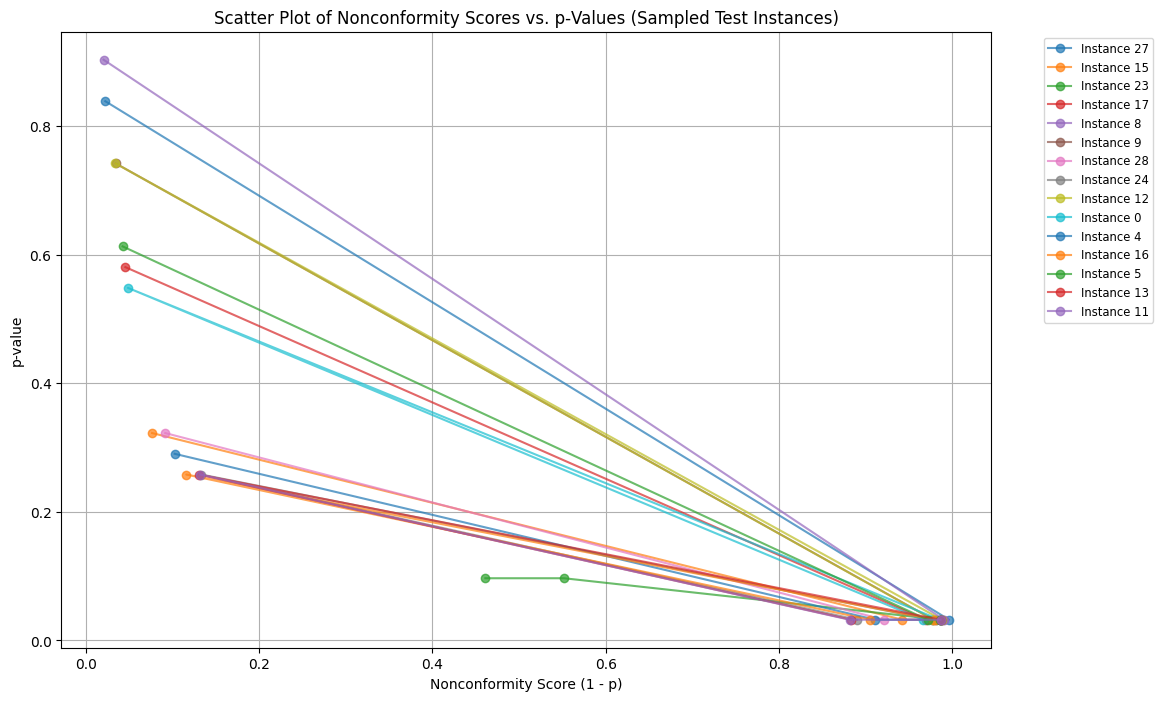

In [21]:
# %% [markdown]
"""
## Cell D: Scatter Plot: Nonconformity Scores vs. p‑Values for Test Instances
For a sample of test instances, we plot the nonconformity scores and corresponding p‑values for each candidate class.
This plot shows the inverse relation between predicted probability and nonconformity.
"""

# %% [code]
# For a random subset of test instances, plot nonconformity score vs. p-value for each class.
num_samples_to_plot = 15
sample_indices = np.random.choice(range(len(X_test)), size=num_samples_to_plot, replace=False)

plt.figure(figsize=(12, 8))
for idx in sample_indices:
    p_vals, nc_scores = compute_p_values(X_test[idx], svm_model, cal_nonconformity, n_cal)
    classes = list(p_vals.keys())
    p_values = [p_vals[c] for c in classes]
    nonconf_scores = [nc_scores[c] for c in classes]
    # Plot p-values and nonconformity scores as paired points connected by lines.
    plt.plot(nonconf_scores, p_values, marker='o', linestyle='-', alpha=0.7, label=f"Instance {idx}")

plt.xlabel("Nonconformity Score (1 - p)")
plt.ylabel("p-value")
plt.title("Scatter Plot of Nonconformity Scores vs. p‑Values (Sampled Test Instances)")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize='small')
plt.show()

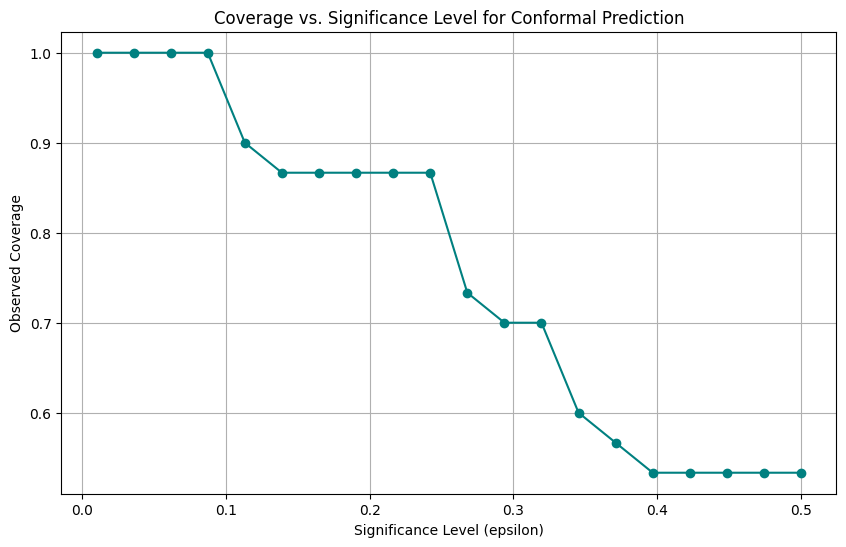

In [22]:
# %% [markdown]
"""
## Cell E: Coverage vs. Significance Level Curve
We plot the observed coverage of the conformal predictor (fraction of test instances whose true label is in the prediction set)
as a function of varying the significance level \(\epsilon\). This curve helps assess the reliability of the uncertainty estimates.
"""

# %% [code]
epsilon_values = np.linspace(0.01, 0.5, 20)
coverage_values = []
for eps in epsilon_values:
    cov = 0
    for i in range(len(y_test)):
        # For each test instance, recompute the prediction set with the new epsilon
        p_vals, _ = compute_p_values(X_test[i], svm_model, cal_nonconformity, n_cal)
        pred_set = [cls for cls, p_val in p_vals.items() if p_val > eps]
        if y_test[i] in pred_set:
            cov += 1
    coverage_values.append(cov / len(y_test))

plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, coverage_values, marker='o', linestyle='-', color='teal')
plt.xlabel("Significance Level (epsilon)")
plt.ylabel("Observed Coverage")
plt.title("Coverage vs. Significance Level for Conformal Prediction")
plt.grid(True)
plt.show()

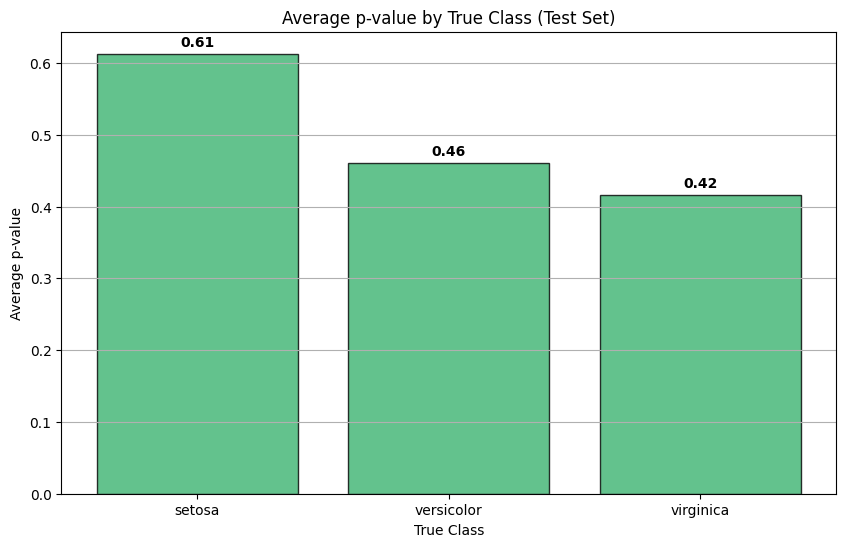

In [23]:
# %% [markdown]
"""
## Cell F: Bar Plot of Average p‑Value by True Class
We compute the average p‑value (across test instances) for each candidate class when it is the true label.
This plot gives insight into how confidently the SVM is predicting each class on average.
"""

# %% [code]
# For each test instance, store the p-value corresponding to the true class.
true_class_pvalues = {i: [] for i in range(len(target_names))}
for i in range(len(y_test)):
    p_vals, _ = compute_p_values(X_test[i], svm_model, cal_nonconformity, n_cal)
    true_class = y_test[i]
    true_class_pvalues[true_class].append(p_vals[true_class])

# Compute average p-value for each class.
avg_pvalues = {target_names[k]: np.mean(v) for k, v in true_class_pvalues.items()}

plt.figure(figsize=(10, 6))
plt.bar(list(avg_pvalues.keys()), list(avg_pvalues.values()), color='mediumseagreen', edgecolor='k', alpha=0.8)
plt.xlabel("True Class")
plt.ylabel("Average p-value")
plt.title("Average p-value by True Class (Test Set)")
for i, v in enumerate(list(avg_pvalues.values())):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold')
plt.grid(True, axis='y')
plt.show()

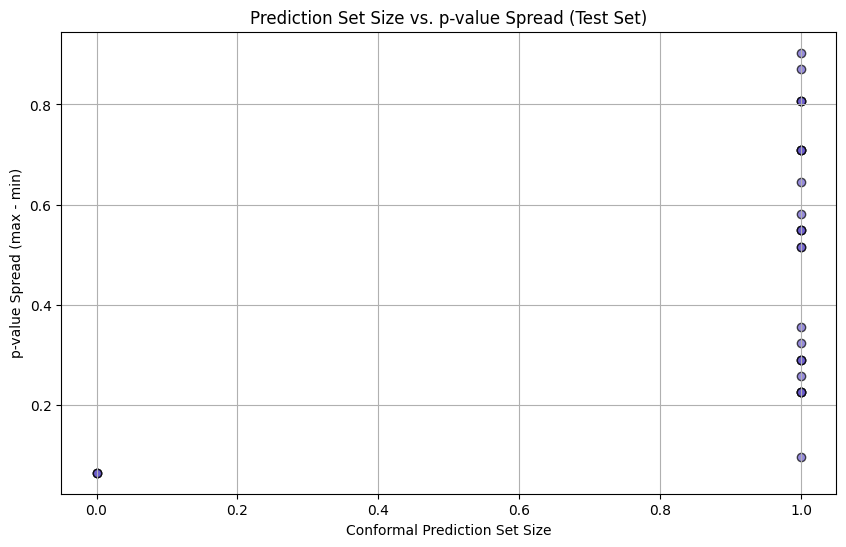

'\n# End of Additional Plots\nThese additional visualizations provide further insight into the performance of the SVM classifier and the conformal prediction uncertainty estimates. Experiment with adjusting parameters and significance levels to explore the behavior of your conformal predictor.\n'

In [24]:
# %% [markdown]
"""
## Cell G: Scatter Plot of Prediction Set Size vs. p-value Spread
For each test instance, we compute the spread (range) of p-values across candidate classes and plot it against the size of the conformal prediction set.
This can reveal whether a more “confident” prediction (narrow spread) tends to result in smaller prediction sets.
"""

# %% [code]
pvalue_spreads = []
for p_dict in all_p_values:
    # Spread defined as max - min of p-values for that instance.
    pvalue_spreads.append(np.max(list(p_dict.values())) - np.min(list(p_dict.values())))

plt.figure(figsize=(10, 6))
plt.scatter(pred_set_sizes, pvalue_spreads, color='slateblue', alpha=0.7, edgecolor='k')
plt.xlabel("Conformal Prediction Set Size")
plt.ylabel("p-value Spread (max - min)")
plt.title("Prediction Set Size vs. p-value Spread (Test Set)")
plt.grid(True)
plt.show()

# %% [markdown]
"""
# End of Additional Plots
These additional visualizations provide further insight into the performance of the SVM classifier and the conformal prediction uncertainty estimates. Experiment with adjusting parameters and significance levels to explore the behavior of your conformal predictor.
"""

In [26]:
# prompt: show the sets of predictions of the conformal prediction

# Assuming conformal_sets is defined as in the provided code.
print("First 10 conformal prediction sets for test instances:")
for i in range(10):
    # Display candidate class names using iris.target_names
    set_names = [target_names[cls] for cls in conformal_sets[i]]
    print(f"Test instance {i}: {set_names}")


First 10 conformal prediction sets for test instances:
Test instance 0: ['versicolor']
Test instance 1: ['setosa']
Test instance 2: ['versicolor']
Test instance 3: ['setosa']
Test instance 4: ['virginica']
Test instance 5: ['setosa']
Test instance 6: ['versicolor']
Test instance 7: ['setosa']
Test instance 8: ['virginica']
Test instance 9: ['setosa']


In [28]:
# prompt: try to introduce noise in the dataset and retrain the model to show that the conformal predcition can predict both classes or none class. show the intermediate calculation that led to decision to include both classes or none class

# Add noise to the dataset
noise_level = 0.1  # Adjust the noise level as needed
X_test_noisy = X_test + noise_level * np.random.randn(*X_test.shape)

# Retrain the model (optional, but often beneficial with noisy data)
# You might consider using a more robust model or adjusting hyperparameters
svm_model_noisy = SVC(probability=True, kernel='rbf', C=1, gamma='scale', random_state=42)  # Example: Retrain with same parameters
svm_model_noisy.fit(X_train, y_train)

# Compute nonconformity scores for the noisy test set
noisy_cal_nonconformity = np.zeros(len(X_cal))
for i in range(len(X_cal)):
    probs = svm_model_noisy.predict_proba(X_cal[i].reshape(1, -1))[0]
    noisy_cal_nonconformity[i] = 1 - probs[y_cal[i]]

# Compute p-values and prediction sets for noisy data
epsilon = 0.1
noisy_conformal_sets = []
for x in X_test_noisy:
    p_vals, _ = compute_p_values(x, svm_model_noisy, noisy_cal_nonconformity, len(X_cal))
    pred_set = [cls for cls, p_val in p_vals.items() if p_val > epsilon]
    noisy_conformal_sets.append(pred_set)

# Analyze the results
for i in range(10):
    set_names = [target_names[cls] for cls in noisy_conformal_sets[i]]
    print(f"Noisy Test instance {i}: {set_names}")
    p_vals, nc_scores = compute_p_values(X_test_noisy[i], svm_model_noisy, noisy_cal_nonconformity, len(X_cal))
    print("  Nonconformity scores:", {target_names[k]: round(v, 3) for k, v in nc_scores.items()})
    print("  p-values:", {target_names[k]: round(v, 3) for k, v in p_vals.items()})
    # ... rest of your analysis

# Example: Checking for empty or multi-class prediction sets
for i in range(len(noisy_conformal_sets)):
    if not noisy_conformal_sets[i]:  # Empty set
        print(f"Test instance {i}: No class predicted (empty prediction set)")
    elif len(noisy_conformal_sets[i]) > 1:
        print(f"Test instance {i}: Multiple classes predicted: {noisy_conformal_sets[i]}")



Noisy Test instance 0: ['versicolor']
  Nonconformity scores: {'setosa': 0.986, 'versicolor': 0.083, 'virginica': 0.931}
  p-values: {'setosa': 0.032, 'versicolor': 0.323, 'virginica': 0.032}
Noisy Test instance 1: ['setosa']
  Nonconformity scores: {'setosa': 0.035, 'versicolor': 0.978, 'virginica': 0.987}
  p-values: {'setosa': 0.742, 'versicolor': 0.032, 'virginica': 0.032}
Noisy Test instance 2: ['versicolor']
  Nonconformity scores: {'setosa': 0.986, 'versicolor': 0.262, 'virginica': 0.751}
  p-values: {'setosa': 0.032, 'versicolor': 0.129, 'virginica': 0.032}
Noisy Test instance 3: ['setosa']
  Nonconformity scores: {'setosa': 0.033, 'versicolor': 0.98, 'virginica': 0.988}
  p-values: {'setosa': 0.742, 'versicolor': 0.032, 'virginica': 0.032}
Noisy Test instance 4: ['virginica']
  Nonconformity scores: {'setosa': 0.986, 'versicolor': 0.927, 'virginica': 0.087}
  p-values: {'setosa': 0.032, 'versicolor': 0.032, 'virginica': 0.323}
Noisy Test instance 5: ['setosa']
  Nonconformity 

In [30]:
# prompt: give the details in code to show why:Test instance 10: No class predicted (empty prediction set)
# Test instance 29: No class predicted (empty prediction set)

# Add noise to the dataset
noise_level = 0.1  # Adjust the noise level as needed
X_test_noisy = X_test + noise_level * np.random.randn(*X_test.shape)

# Retrain the model (optional, but often beneficial with noisy data)
# You might consider using a more robust model or adjusting hyperparameters
svm_model_noisy = SVC(probability=True, kernel='rbf', C=1, gamma='scale', random_state=42)  # Example: Retrain with same parameters
svm_model_noisy.fit(X_train, y_train)

# Compute nonconformity scores for the noisy test set
noisy_cal_nonconformity = np.zeros(len(X_cal))
for i in range(len(X_cal)):
    probs = svm_model_noisy.predict_proba(X_cal[i].reshape(1, -1))[0]
    noisy_cal_nonconformity[i] = 1 - probs[y_cal[i]]

# Compute p-values and prediction sets for noisy data
epsilon = 0.1
noisy_conformal_sets = []
for x in X_test_noisy:
    p_vals, _ = compute_p_values(x, svm_model_noisy, noisy_cal_nonconformity, len(X_cal))
    pred_set = [cls for cls, p_val in p_vals.items() if p_val > epsilon]
    noisy_conformal_sets.append(pred_set)

# Analyze the results
for i in range(10):
    set_names = [target_names[cls] for cls in noisy_conformal_sets[i]]
    print(f"Noisy Test instance {i}: {set_names}")
    p_vals, nc_scores = compute_p_values(X_test_noisy[i], svm_model_noisy, noisy_cal_nonconformity, len(X_cal))
    print("  Nonconformity scores:", {target_names[k]: round(v, 3) for k, v in nc_scores.items()})
    print("  p-values:", {target_names[k]: round(v, 3) for k, v in p_vals.items()})
    # ... rest of your analysis

# Example: Checking for empty or multi-class prediction sets
for i in range(len(noisy_conformal_sets)):
    if not noisy_conformal_sets[i]:  # Empty set
        print(f"Test instance {i}: No class predicted (empty prediction set)")
    elif len(noisy_conformal_sets[i]) > 1:
        print(f"Test instance {i}: Multiple classes predicted: {noisy_conformal_sets[i]}")


Noisy Test instance 0: ['versicolor']
  Nonconformity scores: {'setosa': 0.985, 'versicolor': 0.038, 'virginica': 0.977}
  p-values: {'setosa': 0.032, 'versicolor': 0.677, 'virginica': 0.032}
Noisy Test instance 1: ['setosa']
  Nonconformity scores: {'setosa': 0.033, 'versicolor': 0.98, 'virginica': 0.988}
  p-values: {'setosa': 0.742, 'versicolor': 0.032, 'virginica': 0.032}
Noisy Test instance 2: ['versicolor']
  Nonconformity scores: {'setosa': 0.987, 'versicolor': 0.196, 'virginica': 0.817}
  p-values: {'setosa': 0.032, 'versicolor': 0.161, 'virginica': 0.032}
Noisy Test instance 3: ['setosa']
  Nonconformity scores: {'setosa': 0.035, 'versicolor': 0.977, 'virginica': 0.987}
  p-values: {'setosa': 0.71, 'versicolor': 0.032, 'virginica': 0.032}
Noisy Test instance 4: ['virginica']
  Nonconformity scores: {'setosa': 0.986, 'versicolor': 0.924, 'virginica': 0.09}
  p-values: {'setosa': 0.032, 'versicolor': 0.032, 'virginica': 0.323}
Noisy Test instance 5: ['setosa']
  Nonconformity sc